In [195]:
# Load data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import LatentDirichletAllocation


# load data
df = pd.read_csv("counts.csv", header=None, index_col=None)
df2 = pd.read_csv("vocabulary.csv", header=None, index_col=None)

# create empty_matrix to be sparse document feature matrix
empty_matrix = np.zeros((24998, 2073))

# load empty_matrix with values
for index, row in df.iterrows():
    document_id = row[0] - 1
    word_id = row[1] - 1
    word_count = row[2]
    empty_matrix[document_id][word_id] = word_count







 Fitting LDA models
done in 46.699s.


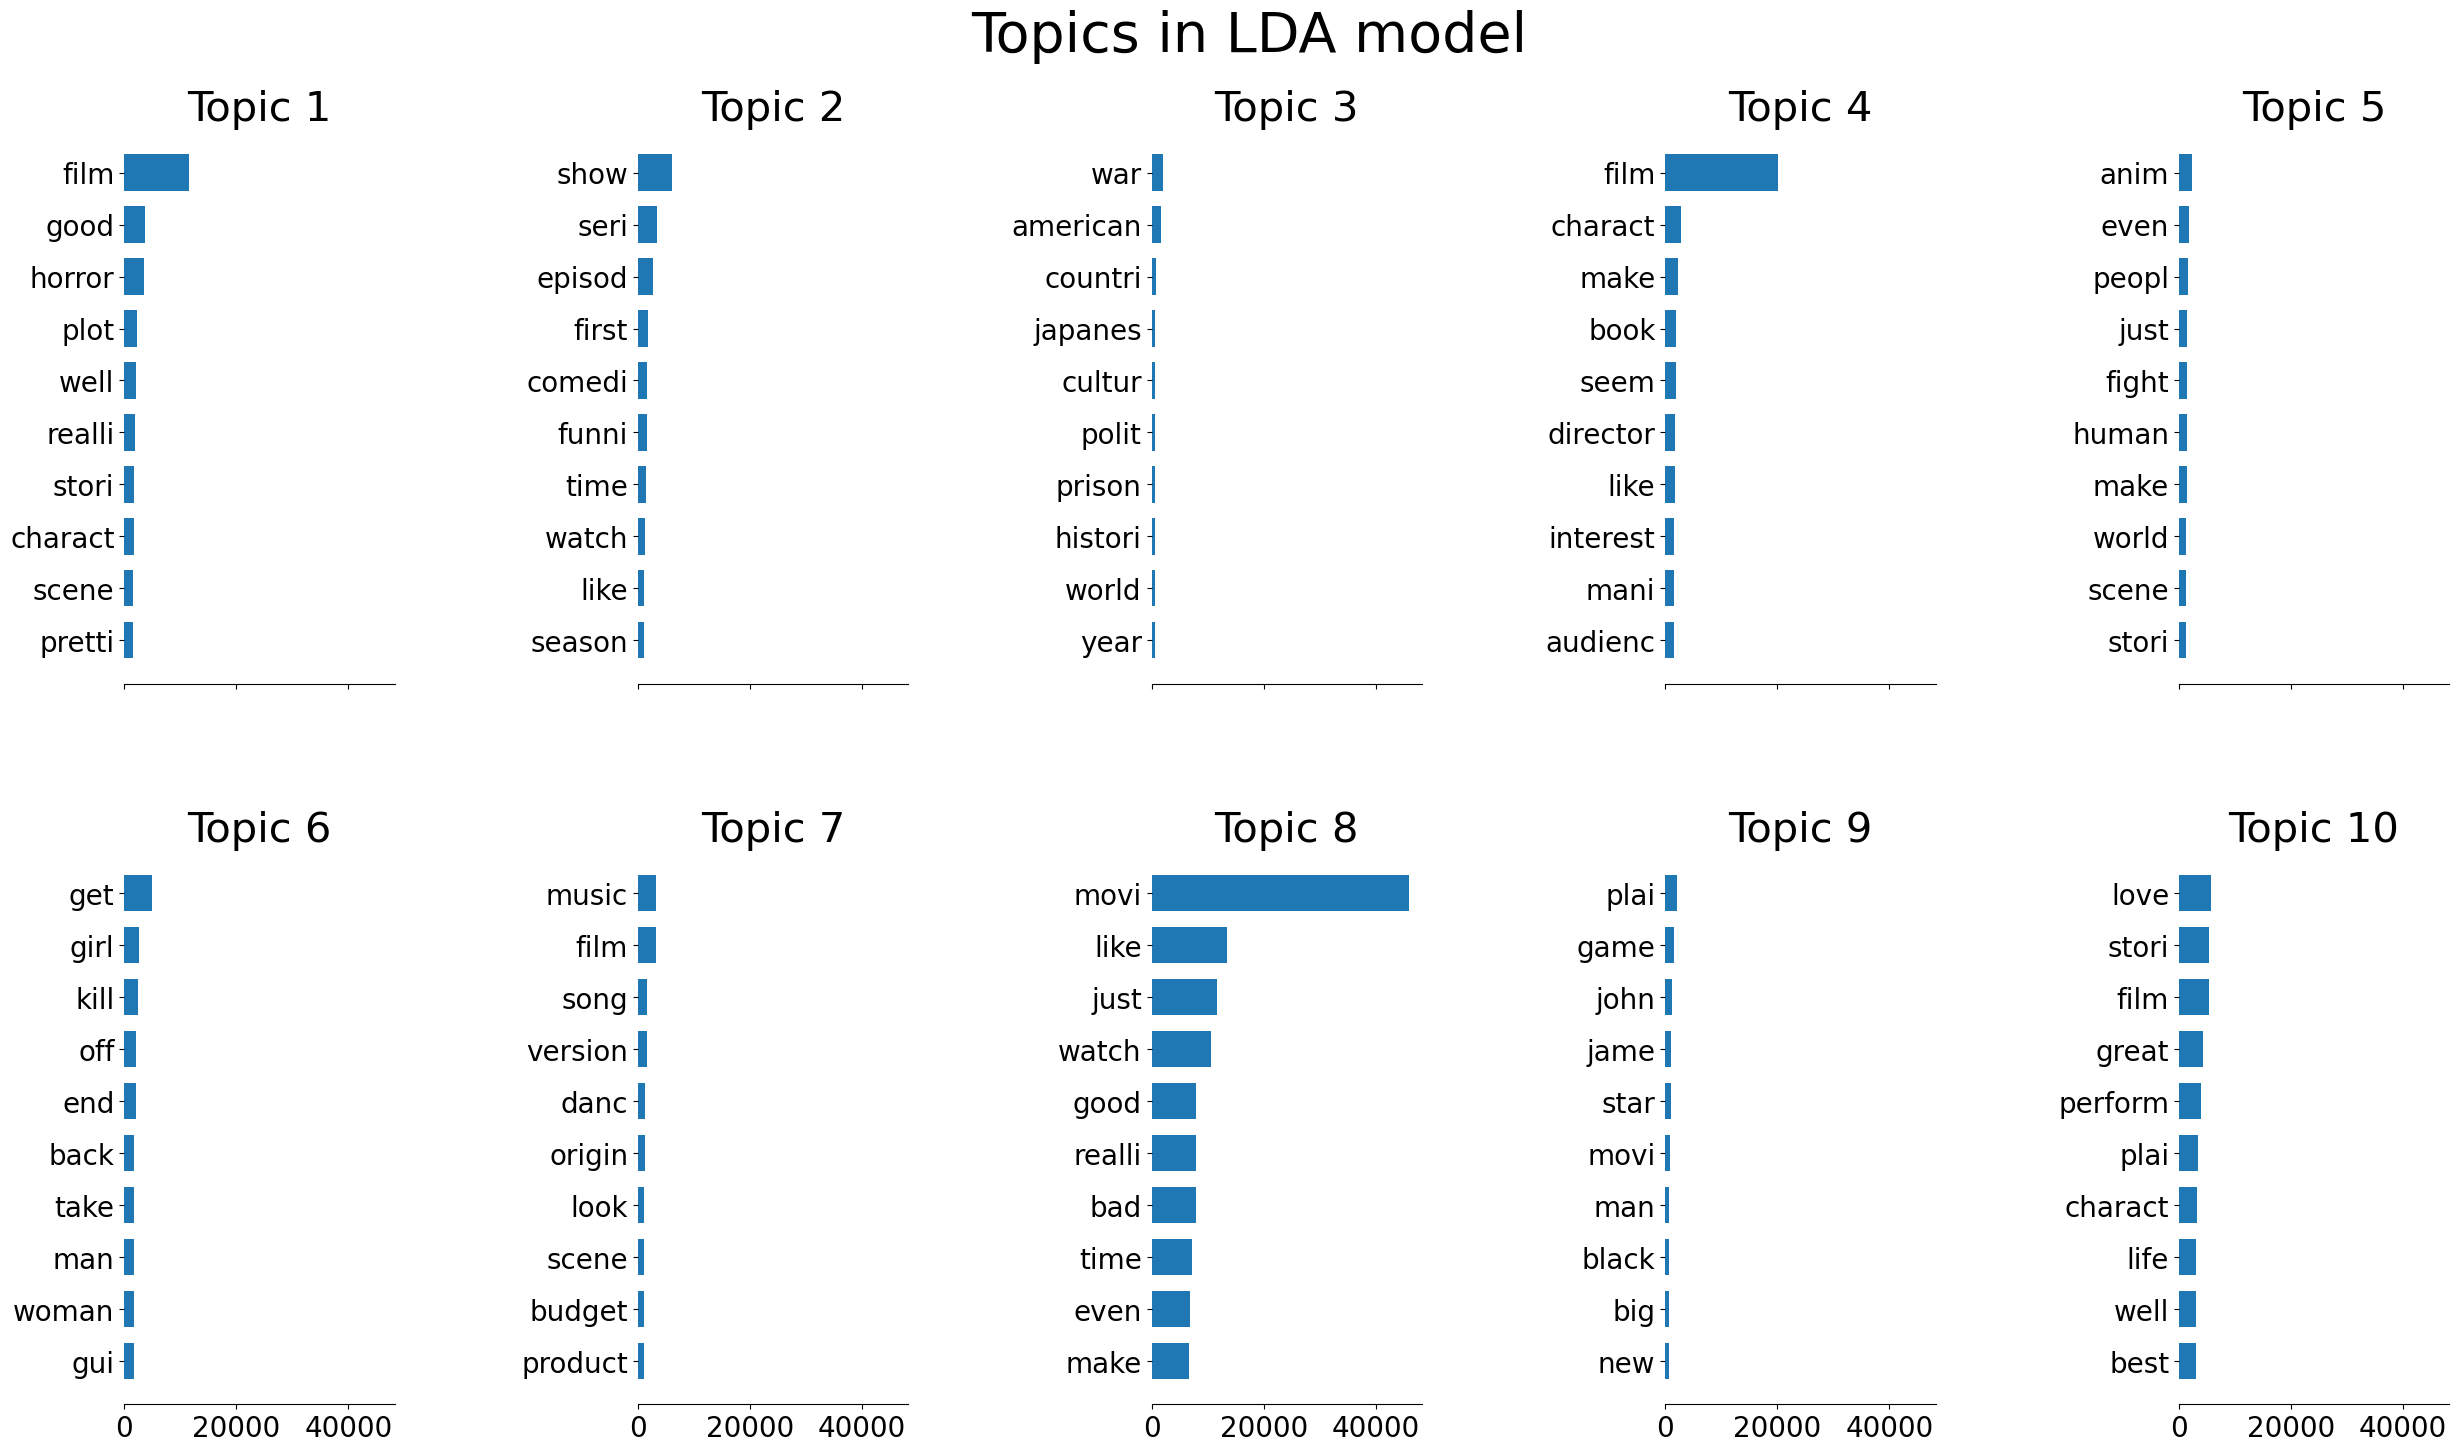

In [196]:
'''
The below code was generated by modifying example code to plot the top words within each top found at 
https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

'''
from time import time

# function to plot topics and their top words
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


# load feature names
empty_matrix_feature_names = df2
empty_matrix_feature_names = df2.iloc[0].values

    
print(
    "\n" * 2,
    "Fitting LDA models..."
)
# use online learning to speed up
lda = LatentDirichletAllocation(
    n_components=10,
    learning_method="online",
    random_state=0,
)
t0 = time()
lda.fit(empty_matrix)
print("done in %0.3fs." % (time() - t0))

# plot top words
plot_top_words(lda, empty_matrix_feature_names, 10, "Topics in LDA model")

(24998, 1973)
(24998, 2073)
1973


 Fitting LDA model...
done in 37.283s.


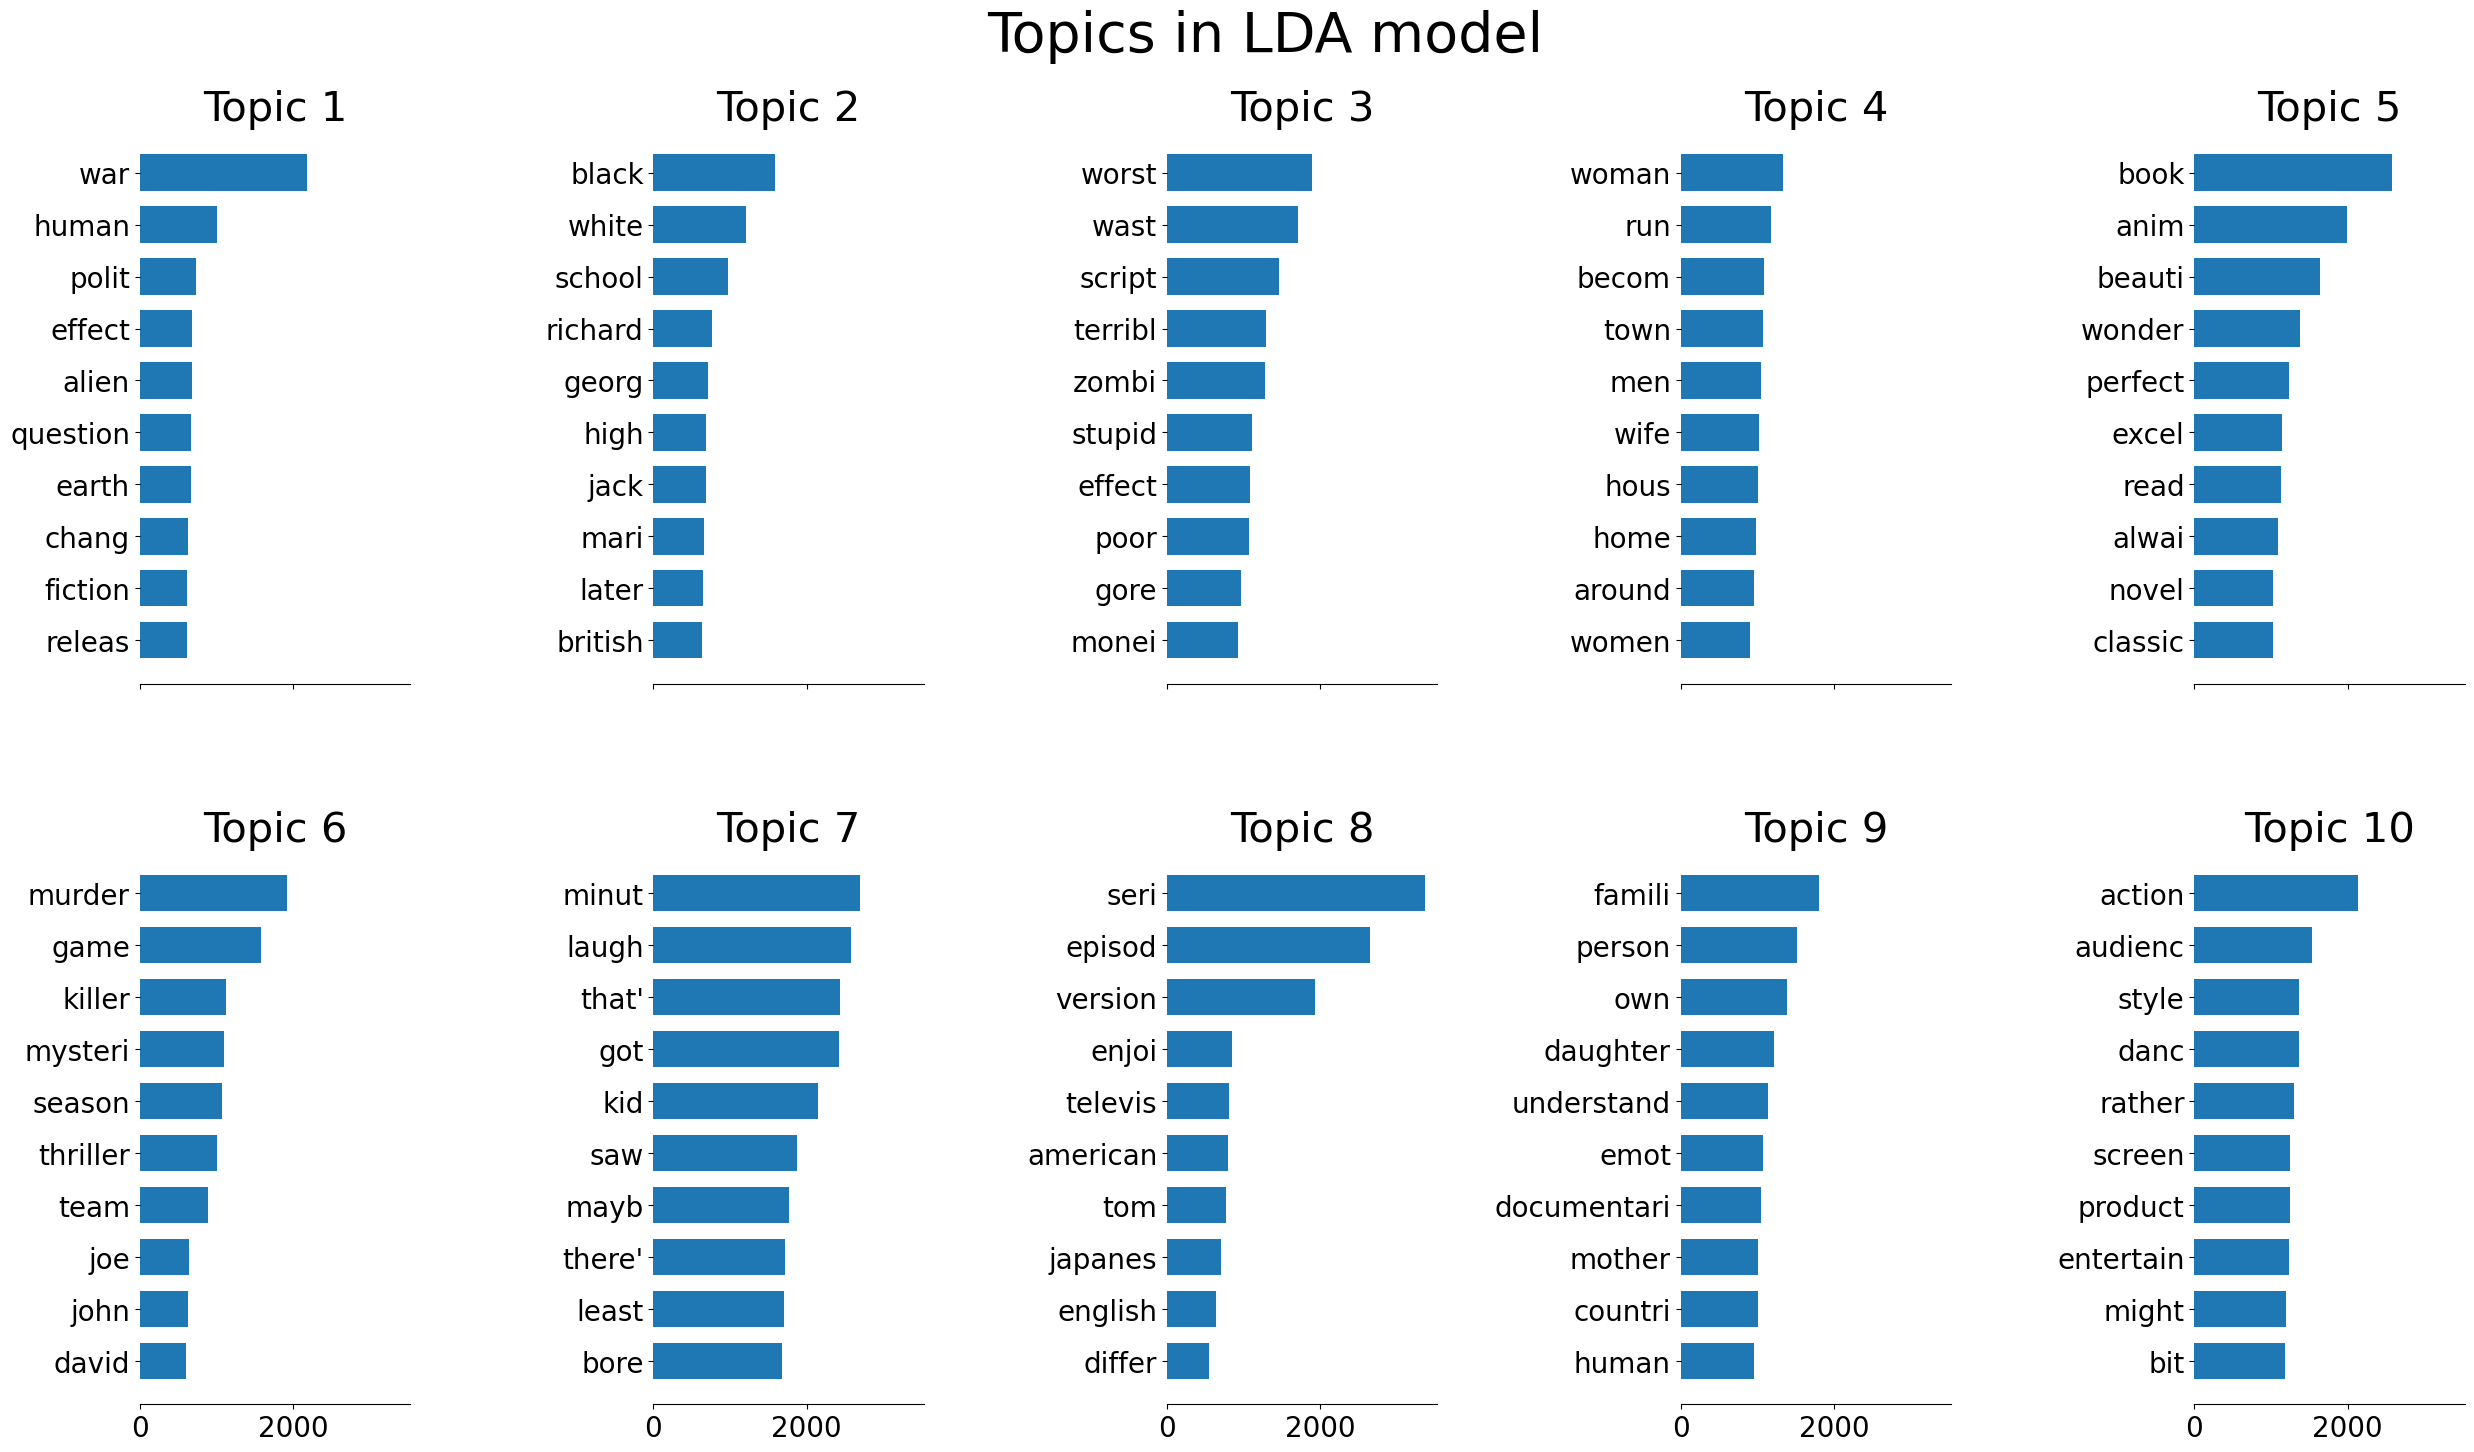

In [198]:
# Part B
# Remove top 100 words

# compute word frequencies across all docs
word_frequencies = empty_matrix.sum(axis=0)

# get the indices of top 100 words
top_words_indices = word_frequencies.argsort()[-100:]


# delete the top words from the featutre matrix and names matrix
filtered_feature_matrix = np.delete(empty_matrix, top_words_indices, axis=1)
filtered_feature_names = np.delete(empty_matrix_feature_names, top_words_indices)

# examine the results of filtering 
print(filtered_feature_matrix.shape)
print(empty_matrix.shape)
print(len(filtered_feature_names))

# perform lda and plot like in part a
print(
    "\n" * 2,
    "Fitting LDA model..."
)
lda = LatentDirichletAllocation(
    n_components=10,
    learning_method="online",
    random_state=0,
)
t0 = time()
lda.fit(filtered_feature_matrix)
print("done in %0.3fs." % (time() - t0))

plot_top_words(lda, filtered_feature_names, 10, "Topics in LDA model")

In [88]:
# Part C
# find average sentiment of top 500 reviews for each topic
# perform lda with filted features as in part b
print(
    "\n" * 2,
    "Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
    % (1000000, 21222),
)
lda = LatentDirichletAllocation(
    n_components=10,
    learning_method="online",
    random_state=0,
)

# fit and transform with lda model
lda_topic_matrix = lda.fit_transform(filtered_feature_matrix)

# get the best fit topic for each doc
dominant_topics = lda_topic_matrix.argmax(axis=1)

print(dominant_topics)



 Fitting LDA models with tf features, n_samples=1000000 and n_features=21222...
[3 0 6 ... 6 8 8]


In [203]:
# Part c continued

# read sentimate data
sent_df = pd.read_csv("sentiment.csv", header=None, index_col=None)
# find indices of top 500 values for each topic column
top_500_indices = np.argpartition(lda_topic_matrix, -500, axis=0)[-500:, :]


# map each index to pos or neg
sentimat_array = np.zeros((500,10))
i = 0
for row in top_500_indices:
    j = 0
    for index in row:
        sentimat_array[i][j] = sent_df[index]
        j += 1

sentimat_avgs = np.mean(sentimat_array, axis=0)
print(sentimat_avgs)



(24998, 10)
[0.002 0.    0.    0.    0.002 0.002 0.    0.002 0.002 0.   ]


In [201]:
# Part d
from sklearn.feature_extraction.text import TfidfTransformer


# read sentimate data
sent_df = pd.read_csv("sentiment.csv", header=None, index_col=None)


# convert dataframe to 1D numpy array
sent_array = sent_df.values.flatten()


# find indices where value is 0(neg) or 1(pos)
neg_indices = np.where(sent_array == 0)
pos_indices = np.where(sent_array == 1)



# create neg_revies array
neg_reviews = np.delete(empty_matrix, pos_indices, axis=0)

# create pos revies array
pos_reviews = empty_matrix[pos_indices, :]
pos_reviews = np.squeeze(pos_reviews, axis=0)


# Step 2: Create a TfidfTransformer to transform the count matrix into tf-idf
tfidf_transformer = TfidfTransformer()
neg_tfidf_matrix = tfidf_transformer.fit_transform(neg_reviews)
pos_tfidf_matrix = tfidf_transformer.fit_transform(pos_reviews)

# convert the sparse matrix to a dense array
corrected_neg_tfidf_matrix = np.array(neg_tfidf_matrix.todense())
corrected_pos_tfidf_matrix = np.array(pos_tfidf_matrix.todense())

# print the tf-idf matrix shapes to check if it looks right
print("\nTF-IDF Matrix shapes:")
print(corrected_neg_tfidf_matrix.shape)
print(corrected_pos_tfidf_matrix.shape)

# find average tf-idf score for each word across the docuemnets
neg_averages = np.mean(corrected_neg_tfidf_matrix, axis=0)
pos_averages = np.mean(corrected_pos_tfidf_matrix, axis=0)

# find abs difference between vectors
absolute_difference = np.abs(neg_averages - pos_averages)

# sort the array in decreasing order
indices_descending_order = np.argsort(absolute_difference)[::-1]
sorted_array = np.sort(absolute_difference)[::-1]


# print the words with the largest difference
print("Top 20 words wih the largest TfDif score difference")
for index in indices_descending_order[:20]:
    print(empty_matrix_feature_names[index])

print("\n\nBottom 20 words wih the smallest TfDif score difference")
# print the words with the least difference
for index in indices_descending_order[-20:]:
    print(empty_matrix_feature_names[index])


TF-IDF Matrix shapes:
(12500, 2073)
(12498, 2073)
Top 20 words wih the largest TfDif score difference
bad
worst
great
wast
love
movi
bore
just
terribl
even
excel
best
stupid
noth
horribl
wors
plot
minut
why
act


Bottom 20 words wih the smallest TfDif score difference
level
suspens
frustrat
brief
circumst
jone
break
bear
luck
camp
woman
offer
order
forget
common
soft
expos
punch
everi
heroin
